# A benchmark Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

In [2]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [4]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [108]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [109]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2013',
                                                             '31-12-2015'),
                                                            ('01-01-2016',
                                                             '31-12-2016'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 105 tickers after removing tickers with Nan values


In [110]:
len(df_prices_train)+len(df_prices_test)

78222

# Load Pairs

In [111]:
# intra day
with open('data/etfs/pickle/2013-2017/pairs_no_clustering_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

#with open('data/etfs/pickle/2013-2017/pairs_no_clustering_intraday_nohurst.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

#with open('data/etfs/pickle/2013-2017/pairs_no_clustering_intraday_only_coint.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

In [113]:
len(pairs)

247

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [114]:
train_val_split = '2015-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [116]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 247/247

Average SR:  1.3742445764845541
Annual ROI:  19.791661049805565
90.2834008097166 % of the pairs had positive returns
Sharpe Ratio using annual return 5.129459438792814
Autocorrelation:  -0.14158140950834508
Daily Sharpe Ratio 0.2960355704434527
Portfolio Sharpe Ratio:  0.2960355704434527
Total number of trades:  581
Positive trades:  511
Negative trades:  70
Max DD period: 3.0 days
Maximum drawdown of portfolio: -2.37%


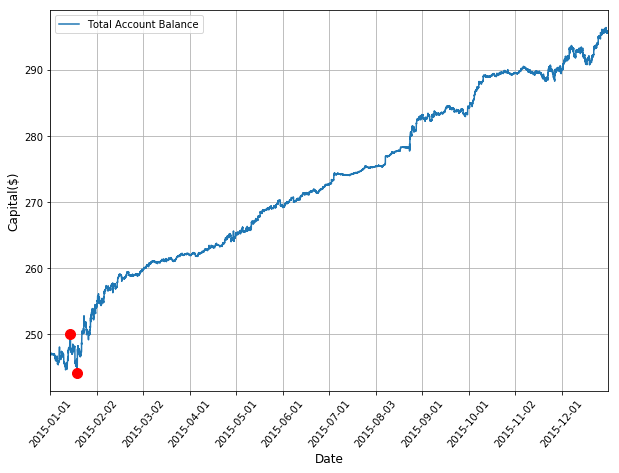

In [117]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [121]:
print('Corrected Annualized SR: {:.2f}'.format(0.2960355704434527*17.47))

Corrected Annualized SR: 5.17


In [ ]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [ ]:
#cum_returns_threshold_train_w_costs

In [ ]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [122]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [123]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 247/247

Average SR:  1.5100468060202412
Annual ROI:  24.801318566851684
86.23481781376518 % of the pairs had positive returns
Sharpe Ratio using annual return 6.065427423139689
Autocorrelation:  0.25186244152217346
Daily Sharpe Ratio 0.3409962624489464
Portfolio Sharpe Ratio:  0.3409962624489464
Total number of trades:  411
Positive trades:  369
Negative trades:  42
Max DD period: 5.0 days
Maximum drawdown of portfolio: -2.05%


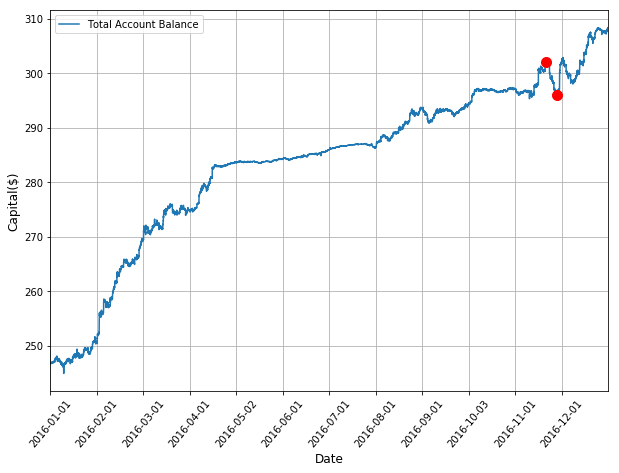

In [124]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [134]:
print('Corrected Annualized SR: {:.2f}'.format(0.3409962624489464*11.62))

Corrected Annualized SR: 3.96


### Approach 2: Keeping only pairs that had positive returns in the training period

In [125]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [126]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 223/223

Average SR:  1.57330652342033
Annual ROI:  26.346869524401974
86.09865470852019 % of the pairs had positive returns
Sharpe Ratio using annual return 6.245996510994825
Autocorrelation:  0.24233093719470808
Daily Sharpe Ratio 0.3489642352608839
Portfolio Sharpe Ratio:  0.3489642352608839
Total number of trades:  361
Positive trades:  329
Negative trades:  32
Max DD period: 5.0 days
Maximum drawdown of portfolio: -1.98%


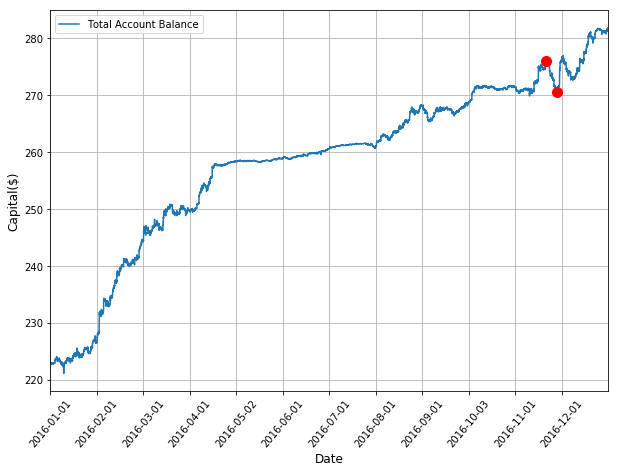

In [127]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [135]:
print('Corrected Annualized SR: {:.2f}'.format(0.3489642352608839*12.92))

Corrected Annualized SR: 4.51


### Approach 3: Keeping only top 10 pairs

In [136]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [137]:
# sorting by returns seems to give better results

In [138]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [131]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 10/10

Average SR:  1.8268963779796288
Annual ROI:  25.97989505595095
90.0 % of the pairs had positive returns
Sharpe Ratio using annual return 4.9099990104653255
Autocorrelation:  0.1688748882215464
Daily Sharpe Ratio 0.2752443096013491
Portfolio Sharpe Ratio:  0.2752443096013491
Total number of trades:  15
Positive trades:  15
Negative trades:  0
Max DD period: 3.0 days
Maximum drawdown of portfolio: -2.65%


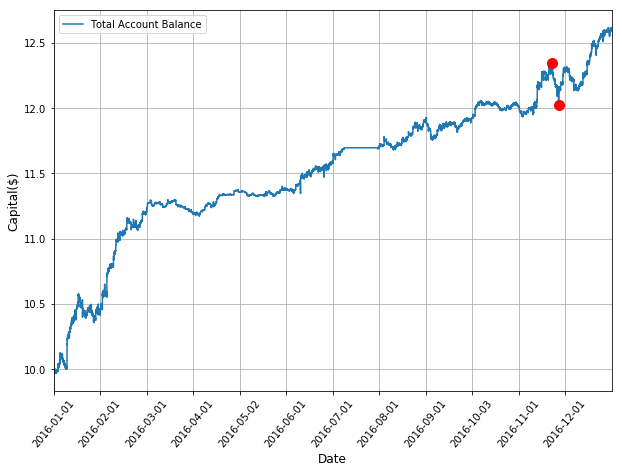

In [132]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  n_years_test)

In [139]:
print('Corrected Annualized SR: {:.2f}'.format(0.2752443096013491*12.92))

Corrected Annualized SR: 3.56


# Validate the results

In [133]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,UCI,Commodities: Broad Market,UNL,Commodities: Energy Natural Gas,-3.630634,0.005202,323,506,0.340676,3,0,3.439200,100.0
1,COPX,Equity: Global Metals & Mining,UCI,Commodities: Broad Market,-3.818192,0.002727,399,588,0.290573,3,0,2.927010,100.0
2,SGOL,Commodities: Precious Metals Gold,URA,Equity: Global Nuclear Energy,-3.647249,0.004919,369,1688,0.496328,1,0,2.226152,100.0
3,GLTR,Commodities: Precious Metals,URA,Equity: Global Nuclear Energy,-3.599898,0.005763,361,1576,0.491858,1,0,2.211251,100.0
4,RJZ,Commodities: Broad Market Metals,URA,Equity: Global Nuclear Energy,-3.618772,0.005412,495,722,0.400730,2,0,2.171310,100.0
5,SILJ,Equity: Global Silver Miners,UCI,Commodities: Broad Market,-3.605904,0.005649,334,1135,0.345695,1,0,1.981727,100.0
6,MLPY,Equity: U.S. MLPs,PICK,Equity: Global Metals & Mining,-4.338911,0.000380,580,930,0.375689,2,0,1.811966,100.0
7,BOIL,Leveraged Commodities: Energy Natural Gas,UCI,Commodities: Broad Market,-3.621489,0.005363,307,628,0.392571,1,0,0.972637,100.0
8,BCM,Commodities: Broad Market,COPX,Equity: Global Metals & Mining,-3.433277,0.009875,296,1051,0.400626,1,0,0.527711,100.0
9,CANE,Commodities: Agriculture Sugar,UGAZ,Leveraged Commodities: Energy Natural Gas,-3.581804,0.006119,225,976,0.419379,0,0,0.000000,NaN
